# Tropical Rain Belt

This notebook (Python 3) uses modern climatological data to define the latitudinal extent of the tropical rain belt.

## Import Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.lines import Line2D

from netCDF4 import Dataset
import cartopy.crs as ccrs

## Read in Data

In [2]:
# temperature
T_nc = Dataset('../Data/climate/tmp.0-10cm.mon.ltm.nc')

# runoff
R_nc = Dataset('../Data/climate/runof.sfc.mon.ltm.nc')

# precipitation
P_nc = Dataset('../Data/climate/prate.sfc.mon.ltm.nc')

# potential evaporation
E_nc = Dataset('../Data/climate/pevpr.sfc.mon.ltm.nc')

# land mask
ls_nc = Dataset('../Data/climate/lsmask.19294.nc')

# evaporation - precipitation
EP_nc = Dataset('../Data/climate/ERAI.EP.1979-2015_annualmean.nc')

# temperature B
Tb_nc = Dataset('../Data/climate/temp1x1.nc')

# runoff B
Rb_nc = Dataset('../Data/climate/runoff1x1.nc')

Notes about the data:

* the following were downloaded directly from https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.surfaceflux.html, and represent long term montly means for the period 1981 - 2010:
    * temperature (tmp.0-10cm.mon.ltm.nc)
    * runoff (runof.sfc.mon.ltm.nc)
    * precipitation (prate.sfc.mon.ltm.nc)
    * potential evaporation (pevpr.sfc.mon.ltm.nc)
    * land mask (lsmask.19294.nc)
* evaporation minus precipitation data were taken from https://climatedataguide.ucar.edu/climate-data/era-interim-derived-components
    * note that the the raw netCDF file (ERAI.EP.1979-2015.nc) was too large to be uploaded to GitHub - we therefore calculate the mean (with respect to time) for each pixel and create a new netCDF file that contains only this mean data, and include this smaller netCDF file within this GitHub repository. The code block below generates this file.
* the alternative temperature (B) data is from the CRU-TS 2.1 database (Climate Research Unit): https://crudata.uea.ac.uk/~timm/grid/CRU_TS_2_1.html
* the alternative runoff (B) data is from UNH-GRDC Composite Runoff Fields V1.0 dataset: http://www.grdc.sr.unh.edu/

## Grid Area

Calculate the area of each grid cell:

In [3]:
dim = (len(T_nc.variables['lat'][:].data), len(T_nc.variables['lon'][:].data))

grid_area = np.zeros(shape=dim)

# authalic radius of the Earth in m
Earth_R = 6371007.2

lat_mins = T_nc.variables['lat'][:].data[:-1] + np.diff(T_nc.variables['lat'][:].data)/2
lat_mins = np.append(np.array([90]), lat_mins)
lat_mins = np.append(lat_mins, np.array([-90]))

# iterate through latitudes
for i in range(dim[0]):
    grid_area[i] = np.abs(np.sin(np.deg2rad(lat_mins[i]))-np.sin(np.deg2rad(lat_mins[i+1])))*\
                   np.sin(np.deg2rad(1.875))*Earth_R**2

## Annual Zonal Means

Show the units that that the raw data is in:

In [4]:
print('T     = {}'.format(T_nc.variables['tmp'].units))
print('R     = {}'.format(R_nc.variables['runof'].units))
print('P     = {}'.format(P_nc.variables['prate'].units))
print('E     = {}'.format(E_nc.variables['pevpr'].units))
print('E - P = kg/m^2/day')

T     = degK
R     = kg/m^2
P     = Kg/m^2/s
E     = W/m^2
E - P = kg/m^2/day


In [5]:
print('T (b) = {}'.format(Tb_nc.variables['temperature'].units))
print('R (b) = {}'.format(Rb_nc.variables['runoff'].units))

T (b) = degrees_celcius
R (b) = m/y


Get an array which has the mean (with respect for time) for each pixel:

In [6]:
# get the annual mean
T_annual_means = np.nanmean(T_nc.variables['tmp'][:,:,:].data, axis=0)
R_annual_means = np.nanmean(R_nc.variables['runof'][:,:,:].data, axis=0)
P_annual_means = np.nanmean(P_nc.variables['prate'][:,:,:].data, axis=0)
E_annual_means = np.nanmean(E_nc.variables['pevpr'][:,:,:].data, axis=0)

# get rid of fill values
T_annual_means[T_annual_means<-100] = np.nan
R_annual_means[R_annual_means<-100] = np.nan
P_annual_means[P_annual_means<-100] = np.nan
E_annual_means[E_annual_means<-100] = np.nan

# we already calculated the annual mean for the E-P data
EP_annual_means = EP_nc.variables['EP'][:,:].data

# these data are already means
Tb_annual_means = Tb_nc.variables['temperature'][:,:].data
Tb_annual_means[Tb_annual_means>=1e30] = np.nan
Rb_annual_means = Rb_nc.variables['runoff'][:,:].data
Rb_annual_means[np.isnan(Tb_annual_means)] = np.nan

Get the zonal means:

In [7]:
T_zonal_means = np.nanmean(T_annual_means, axis=1)
R_zonal_means = np.nanmean(R_annual_means, axis=1)
P_zonal_means = np.nanmean(P_annual_means, axis=1)
E_zonal_means = np.nanmean(E_annual_means, axis=1)
EP_zonal_means = np.nanmean(EP_annual_means, axis=1)
Tb_zonal_means = np.nanmean(Tb_annual_means, axis=1)
Rb_zonal_means = np.nanmean(Rb_annual_means, axis=1)

/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


Convert units of temperature data to C:

In [8]:
T_annual_means = T_annual_means - 273.15
T_zonal_means = T_zonal_means - 273.15

Convert units of precipitation data to m/yr:

In [9]:
P_annual_means = P_annual_means * 31536000 * 0.001
P_zonal_means = P_zonal_means * 31536000 * 0.001

Plot:

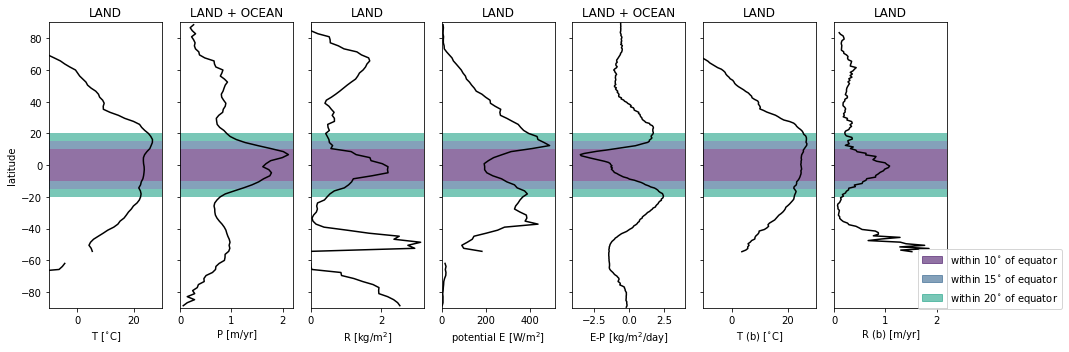

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=7, sharey=True, figsize=(15,5))

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[0].add_patch(degrees_10)
ax[0].add_patch(degrees_15_low)
ax[0].add_patch(degrees_15_high)
ax[0].add_patch(degrees_20_low)
ax[0].add_patch(degrees_20_high)
ax[0].plot(T_zonal_means,T_nc.variables['lat'],color='black')
ax[0].set_xlabel('T [$^{\circ}$C]')
ax[0].set_ylim([-90, 90])
ax[0].set_xlim([-10,30])
ax[0].set_ylabel('latitude')
ax[0].set_title('LAND')

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[1].add_patch(degrees_10)
ax[1].add_patch(degrees_15_low)
ax[1].add_patch(degrees_15_high)
ax[1].add_patch(degrees_20_low)
ax[1].add_patch(degrees_20_high)
ax[1].plot(P_zonal_means,T_nc.variables['lat'],color='black')
ax[1].set_xlabel('P [m/yr]')
ax[1].set_ylim([-90, 90])
ax[1].set_xlim([0, 2.2])
ax[1].set_title('LAND + OCEAN')

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[2].add_patch(degrees_10)
ax[2].add_patch(degrees_15_low)
ax[2].add_patch(degrees_15_high)
ax[2].add_patch(degrees_20_low)
ax[2].add_patch(degrees_20_high)
ax[2].plot(R_zonal_means,T_nc.variables['lat'],color='black')
ax[2].set_xlabel('R [kg/m$^{2}$]')
ax[2].set_ylim([-90, 90])
ax[2].set_xlim([0, 3.2])
ax[2].set_title('LAND')

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[3].add_patch(degrees_10)
ax[3].add_patch(degrees_15_low)
ax[3].add_patch(degrees_15_high)
ax[3].add_patch(degrees_20_low)
ax[3].add_patch(degrees_20_high)
ax[3].plot(E_zonal_means,T_nc.variables['lat'],color='black')
ax[3].set_xlabel('potential E [W/m$^{2}$]')
ax[3].set_ylim([-90, 90])
ax[3].set_xlim([0,510])
ax[3].set_title('LAND')

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[4].add_patch(degrees_10)
ax[4].add_patch(degrees_15_low)
ax[4].add_patch(degrees_15_high)
ax[4].add_patch(degrees_20_low)
ax[4].add_patch(degrees_20_high)
ax[4].plot(EP_zonal_means,EP_nc.variables['lat'],color='black')
ax[4].set_xlabel('E-P [kg/m$^{2}$/day]')
ax[4].set_ylim([-90, 90])
ax[4].set_xlim([-4,4])
ax[4].set_title('LAND + OCEAN')

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[5].add_patch(degrees_10)
ax[5].add_patch(degrees_15_low)
ax[5].add_patch(degrees_15_high)
ax[5].add_patch(degrees_20_low)
ax[5].add_patch(degrees_20_high)
ax[5].plot(Tb_zonal_means,Tb_nc.variables['lat'],color='black')
ax[5].set_xlabel('T (b) [$^{\circ}$C]')
ax[5].set_ylim([-90, 90])
ax[5].set_xlim([-10,30])
ax[5].set_title('LAND')

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[6].add_patch(degrees_10)
ax[6].add_patch(degrees_15_low)
ax[6].add_patch(degrees_15_high)
ax[6].add_patch(degrees_20_low)
ax[6].add_patch(degrees_20_high)
ax[6].plot(Rb_zonal_means,Rb_nc.variables['lat'],color='black')
ax[6].set_xlabel('R (b) [m/yr]')
ax[6].set_ylim([-90, 90])
ax[6].set_xlim([0,2.2])
ax[6].set_title('LAND')

degrees_10 = patches.Patch(linestyle='-', label='within 10$^{\circ}$ of equator',color='#481567',alpha=0.6)
degrees_15 = patches.Patch(label='within 15$^{\circ}$ of equator',color='#33638D',alpha=0.6)
degrees_20 = patches.Patch(label='within 20$^{\circ}$ of equator',color='#20A387',alpha=0.6)
plt.legend(ncol=1,bbox_to_anchor=(0.7, -.02),handles=[degrees_10,degrees_15,degrees_20],loc='lower left')

plt.tight_layout()
plt.show(fig)

## Land Data Only

Note that T, R, and E data are already over land only, except it includes seasonally variable ice sheets.

The resolution of the E-P dataset is different to that of the other data - we therefore resampled the data outside of this notebook using GDAL Warp in QGIS, setting the method to be mode. This crudely makes the E-P dataset compatible with the land-sea mask, so we can extract the land data only.

In [11]:
EP_nc_resampled = Dataset('../Data/climate/ERAI.EP.1979-2015_annualmean_resampled.nc')

In [12]:
# storage arrays
Tland_zonal_means = np.array([])
Rland_zonal_means = np.array([])
Pland_zonal_means = np.array([])
Eland_zonal_means = np.array([])
EPland_zonal_means = np.array([])

# iterate over the latitudes
for i in range(len(T_nc.variables['lat'])):
    
    # latitude storage arrays
    year_T = np.array([])
    year_R = np.array([])
    year_P = np.array([])
    year_E = np.array([])
    
    # iterate over the times
    for j in range(len(T_nc.variables['time'])):
        data_T = T_nc.variables['tmp'][j,i,:].data[ls_nc.variables['lsmask'][0,i,:].data==-1]
        data_T = data_T[data_T>-100]
        data_R = R_nc.variables['runof'][j,i,:].data[ls_nc.variables['lsmask'][0,i,:].data==-1]
        data_R = data_R[data_R>-100]
        data_P = P_nc.variables['prate'][j,i,:].data[ls_nc.variables['lsmask'][0,i,:].data==-1]
        data_P = data_P[data_P>-100]
        data_E = E_nc.variables['pevpr'][j,i,:].data[ls_nc.variables['lsmask'][0,i,:].data==-1]
        data_E = data_E[data_E>-100]
        
        year_T = np.append(year_T, data_T)
        year_R = np.append(year_R, data_R)
        year_P = np.append(year_P, data_P)
        year_E = np.append(year_E, data_E)
        
    # the E-P data is already time averaged, so just get the data for the latitude of interest
    year_EP = EP_nc_resampled.variables['Band1'][i,:].data[ls_nc.variables['lsmask'][0,i,:].data==-1]
        
    # calculate the mean and store
    Tland_zonal_means = np.append(Tland_zonal_means, np.nanmean(year_T))
    Rland_zonal_means = np.append(Rland_zonal_means, np.nanmean(year_R))
    Pland_zonal_means = np.append(Pland_zonal_means, np.nanmean(year_P))
    Eland_zonal_means = np.append(Eland_zonal_means, np.nanmean(year_E))
    EPland_zonal_means = np.append(EPland_zonal_means, np.nanmean(year_EP))

/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


Convert units again:

In [13]:
Tland_zonal_means = Tland_zonal_means - 273.15
Pland_zonal_means = Pland_zonal_means * 31536000 * 0.001

Get the resampled zonal means for the E-P data:

In [14]:
EP_zonal_means_resampled = np.nanmean(EP_nc_resampled.variables['Band1'][:,:].data, axis=1)

Plot:

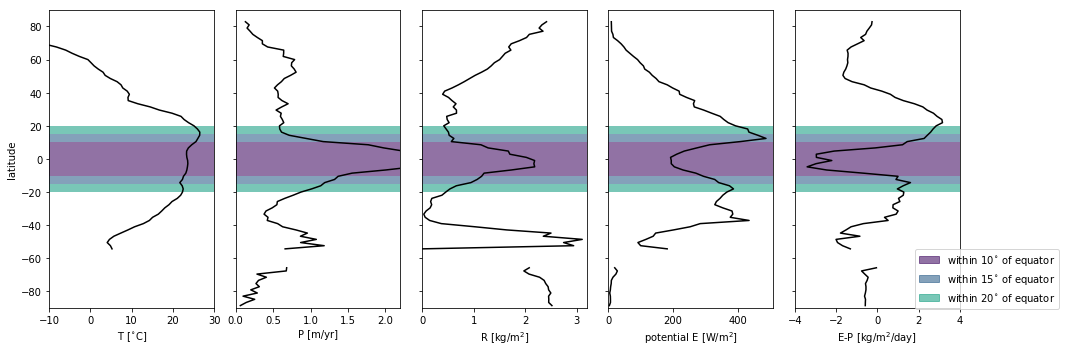

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(15,5))

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[0].add_patch(degrees_10)
ax[0].add_patch(degrees_15_low)
ax[0].add_patch(degrees_15_high)
ax[0].add_patch(degrees_20_low)
ax[0].add_patch(degrees_20_high)
ax[0].plot(Tland_zonal_means,T_nc.variables['lat'],color='black')
ax[0].set_xlabel('T [$^{\circ}$C]')
ax[0].set_ylim([-90, 90])
ax[0].set_xlim([-10,30])
ax[0].set_ylabel('latitude')

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[1].add_patch(degrees_10)
ax[1].add_patch(degrees_15_low)
ax[1].add_patch(degrees_15_high)
ax[1].add_patch(degrees_20_low)
ax[1].add_patch(degrees_20_high)
ax[1].plot(Pland_zonal_means,T_nc.variables['lat'],color='black')
ax[1].set_xlabel('P [m/yr]')
ax[1].set_ylim([-90, 90])
ax[1].set_xlim([0, 2.2])

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[2].add_patch(degrees_10)
ax[2].add_patch(degrees_15_low)
ax[2].add_patch(degrees_15_high)
ax[2].add_patch(degrees_20_low)
ax[2].add_patch(degrees_20_high)
ax[2].plot(Rland_zonal_means,T_nc.variables['lat'],color='black')
ax[2].set_xlabel('R [kg/m$^{2}$]')
ax[2].set_ylim([-90, 90])
ax[2].set_xlim([0, 3.2])

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[3].add_patch(degrees_10)
ax[3].add_patch(degrees_15_low)
ax[3].add_patch(degrees_15_high)
ax[3].add_patch(degrees_20_low)
ax[3].add_patch(degrees_20_high)
ax[3].plot(Eland_zonal_means,T_nc.variables['lat'],color='black')
ax[3].set_xlabel('potential E [W/m$^{2}$]')
ax[3].set_ylim([-90, 90])
ax[3].set_xlim([0,510])

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[4].add_patch(degrees_10)
ax[4].add_patch(degrees_15_low)
ax[4].add_patch(degrees_15_high)
ax[4].add_patch(degrees_20_low)
ax[4].add_patch(degrees_20_high)
ax[4].plot(EPland_zonal_means,T_nc.variables['lat'],color='black')
ax[4].set_xlabel('E-P [kg/m$^{2}$/day]')
ax[4].set_ylim([-90, 90])
ax[4].set_xlim([-4,4])

degrees_10 = patches.Patch(linestyle='-', label='within 10$^{\circ}$ of equator',color='#481567',alpha=0.6)
degrees_15 = patches.Patch(label='within 15$^{\circ}$ of equator',color='#33638D',alpha=0.6)
degrees_20 = patches.Patch(label='within 20$^{\circ}$ of equator',color='#20A387',alpha=0.6)
plt.legend(ncol=1,bbox_to_anchor=(0.7, -.02),handles=[degrees_10,degrees_15,degrees_20],loc='lower left')

plt.tight_layout()
plt.show(fig)

## Maps

In [16]:
def plot_z(lat, lon, z, coastlines=False, output=False, colormap='viridis'):
    """
    Plot data.

    Parameters
    ----------
    lat : latitude vector
    lon : longitude vector
    z : data array
    coastlines : if True, plot modern coastlines. Default False.
    output : if True, return figure and axis handles
    """
    #wrap the longitude vector around an arbitary point in order to fix non-plotting issue on date line
    wrapped_lon = np.concatenate([lon[5:],lon[:5]])
    wrapped_z = np.concatenate([z[:,5:],z[:,:5]],1)

    fig = plt.figure(figsize=(15,6))

    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
    if coastlines:
        ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 color='gray', alpha=0.5, linestyle='--')

    im = ax.pcolormesh(wrapped_lon, lat, wrapped_z, transform=ccrs.PlateCarree())
    im = ax.pcolormesh(lon, lat, z, transform=ccrs.PlateCarree())
    fig.colorbar(im, ax=ax)

    if output!=False:
        return fig, ax

Temperature (C):

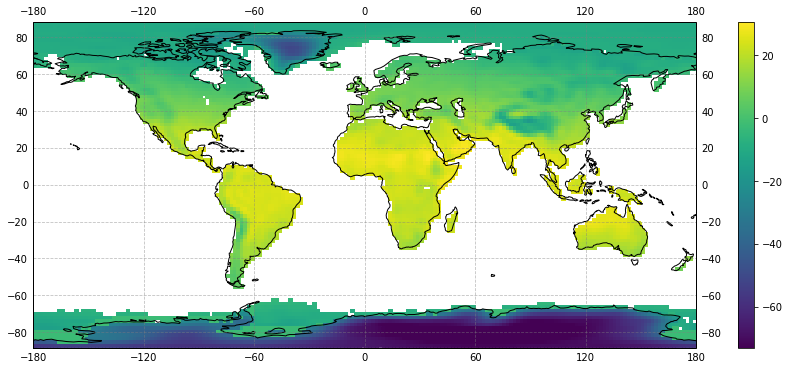

In [17]:
plot_z(T_nc.variables['lat'], T_nc.variables['lon'], T_annual_means, coastlines=True)

Runoff (kg/m$^{2}$)

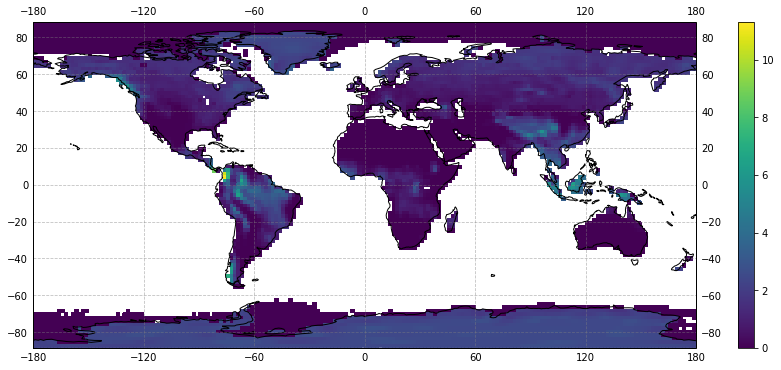

In [18]:
plot_z(T_nc.variables['lat'], T_nc.variables['lon'], R_annual_means, coastlines=True)

Precipitation (m/yr)

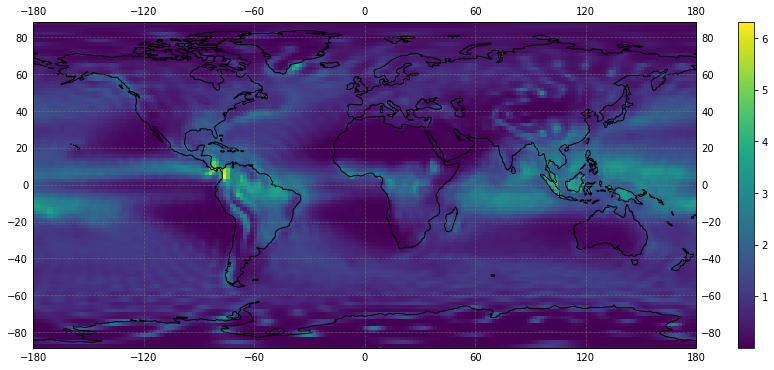

In [19]:
plot_z(T_nc.variables['lat'], T_nc.variables['lon'], P_annual_means, coastlines=True)

Potential evaporation (W/m$^{2}$)

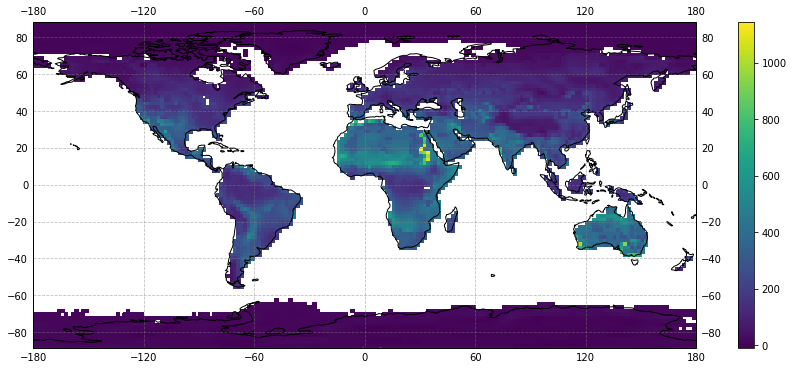

In [20]:
plot_z(T_nc.variables['lat'], T_nc.variables['lon'], E_annual_means, coastlines=True)

Evaporation minus precipitation (kg/m$^{2}$/day)

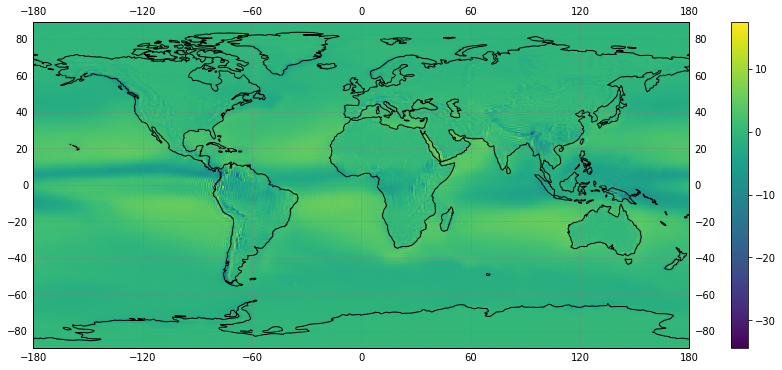

In [21]:
plot_z(EP_nc.variables['lat'], EP_nc.variables['lon'], EP_annual_means, coastlines=True)

Temperature (b) (C):

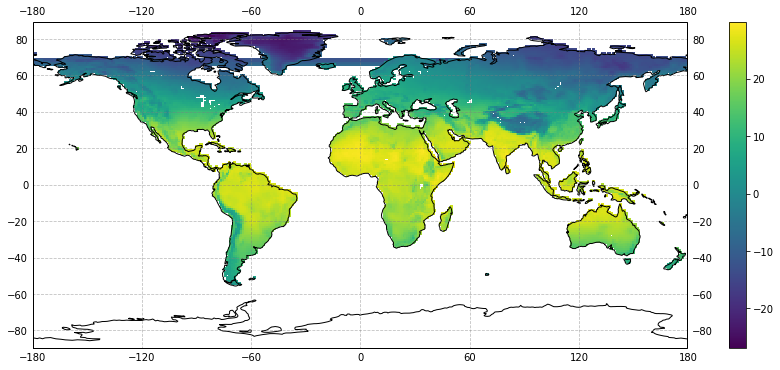

In [22]:
plot_z(Tb_nc.variables['lat'], Tb_nc.variables['lon'], Tb_annual_means, coastlines=True)

Runoff (b) (m/yr):

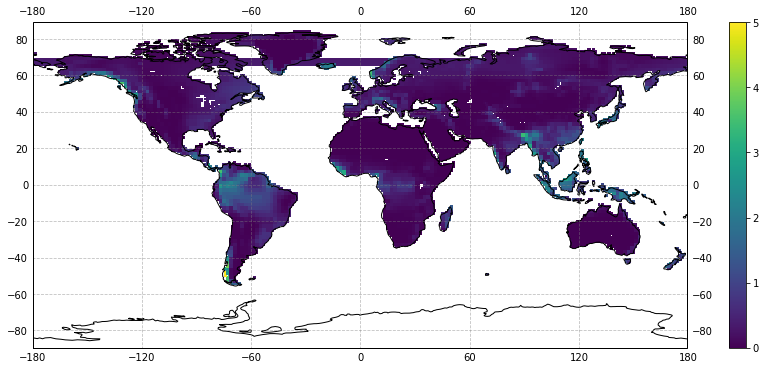

In [23]:
plot_z(Rb_nc.variables['lat'], Rb_nc.variables['lon'], Rb_annual_means, coastlines=True)

## Figure

First, explore artifacts in the runoff data due to low zonal land area in some latitude bands:

In [24]:
# get zonal land area
land_grid_area = grid_area.copy()
land_grid_area[ls_nc.variables['lsmask'][0,:,:].data==0] = 0
zonal_land_area = np.sum(land_grid_area, axis=1)
zonal_land_area_R = zonal_land_area / np.sum(grid_area, axis=1)

zonal_land_area_1deg = np.interp(Rb_nc.variables['lat'][:].data, np.flipud(T_nc.variables['lat'][:].data), np.flipud(zonal_land_area))

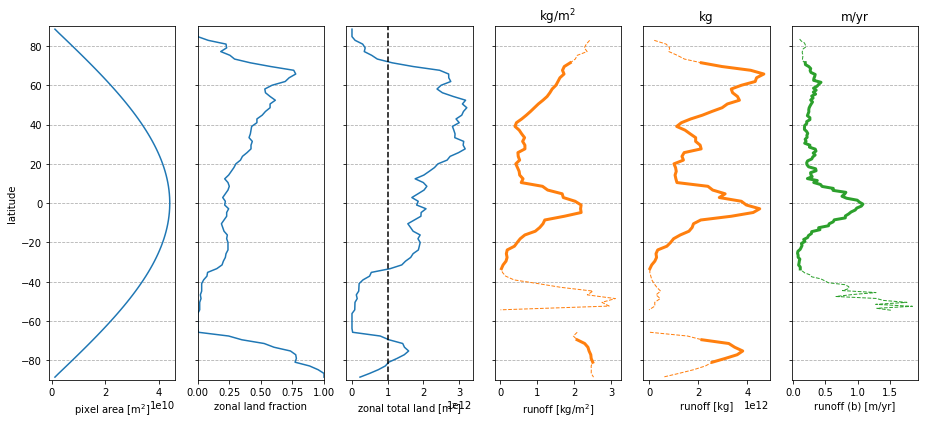

In [25]:
# select the land area threshold
land_area_threshold = 1e12

# mask the data
Rland_zonal_means_masked = Rland_zonal_means.copy()
Rland_zonal_means_masked[zonal_land_area<land_area_threshold] = np.nan

Rland_zonal_total_nc = Rland_zonal_means.copy()
Rland_zonal_total_nc = Rland_zonal_total_nc * zonal_land_area

Rland_zonal_total_nc_masked = Rland_zonal_total_nc.copy()
Rland_zonal_total_nc_masked[zonal_land_area<land_area_threshold] = np.nan

Rb_zonal_means_masked = Rb_zonal_means.copy()
Rb_zonal_means_masked[zonal_land_area_1deg<land_area_threshold] = np.nan

# plot
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(13,6), sharey=True)

ax[0].plot(grid_area[:,0], T_nc.variables['lat'])
ax[0].set_ylim(-90, 90)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('pixel area [m$^{2}$]')

ax[1].plot(zonal_land_area_R, T_nc.variables['lat'])
ax[1].set_xlim(0, 1)
ax[1].set_xlabel('zonal land fraction')

ax[2].plot(zonal_land_area, T_nc.variables['lat'])
ax[2].set_xlabel('zonal total land [m$^{2}$]')
ax[2].axvline(land_area_threshold, ls='--', c='k')

ax[3].plot(Rland_zonal_means,T_nc.variables['lat'], lw='1', c='C1', ls='--')
ax[3].plot(Rland_zonal_means_masked,T_nc.variables['lat'], lw='3', c='C1')
ax[3].set_xlabel('runoff [kg/m$^{2}$]')
ax[3].set_title('kg/m$^{2}$')

ax[4].plot(Rland_zonal_total_nc,T_nc.variables['lat'], lw='1', c='C1', ls='--')
ax[4].plot(Rland_zonal_total_nc_masked,T_nc.variables['lat'], lw='3', c='C1')
ax[4].set_xlabel('runoff [kg]')
ax[4].set_title('kg')

ax[5].plot(Rb_zonal_means,Rb_nc.variables['lat'], lw='1', c='C2', ls='--')
ax[5].plot(Rb_zonal_means_masked,Rb_nc.variables['lat'], lw='3', c='C2')
ax[5].set_xlabel('runoff (b) [m/yr]')
ax[5].set_title('m/yr')

for i in range(len(ax)):
    ax[i].yaxis.grid(ls='--')

fig.tight_layout()
plt.show(fig)

Figure 3 in the manuscript:

Note that we opt to show the runoff data from the UNH-GRDC Composite Runoff Fields V1.0 dataset since it is better documented than the NCEP/NCAR reanalysis data.

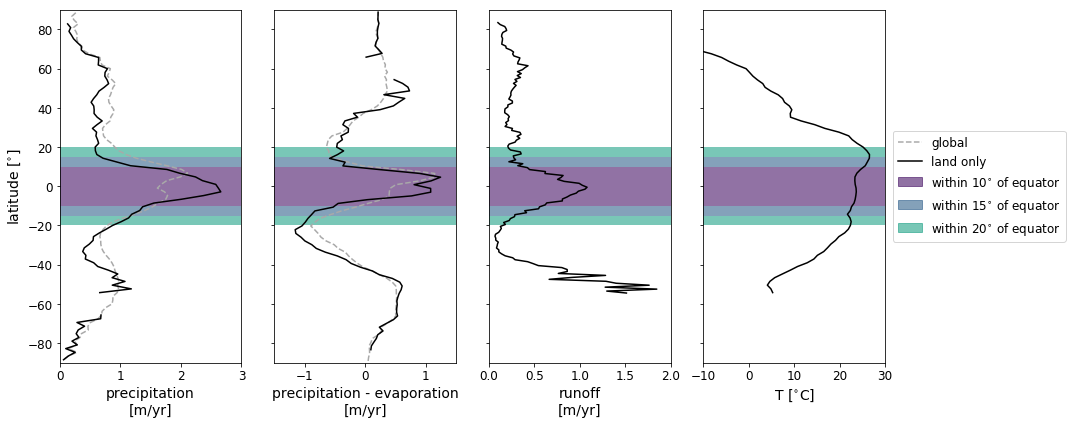

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(15,6))

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[0].add_patch(degrees_10)
ax[0].add_patch(degrees_15_low)
ax[0].add_patch(degrees_15_high)
ax[0].add_patch(degrees_20_low)
ax[0].add_patch(degrees_20_high)
ax[0].plot(P_zonal_means,T_nc.variables['lat'],color='darkgrey',ls='--')
ax[0].plot(Pland_zonal_means,T_nc.variables['lat'],color='black')
ax[0].set_xlabel('precipitation\n[m/yr]', fontsize=14)
ax[0].set_ylim([-90, 90])
ax[0].set_xlim([0, 3])

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[1].add_patch(degrees_10)
ax[1].add_patch(degrees_15_low)
ax[1].add_patch(degrees_15_high)
ax[1].add_patch(degrees_20_low)
ax[1].add_patch(degrees_20_high)
ax[1].plot(-EP_zonal_means_resampled*365.25/1000,EP_nc_resampled.variables['lat'],color='darkgrey', ls='--')
ax[1].plot(-EPland_zonal_means*365.25/1000,EP_nc_resampled.variables['lat'],color='black')
ax[1].set_xlabel('precipitation - evaporation\n[m/yr]', fontsize=14)
ax[1].set_ylim([-90, 90])
ax[1].set_xlim([-1.5,1.5])

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[2].add_patch(degrees_10)
ax[2].add_patch(degrees_15_low)
ax[2].add_patch(degrees_15_high)
ax[2].add_patch(degrees_20_low)
ax[2].add_patch(degrees_20_high)
ax[2].plot(Rb_zonal_means,Rb_nc.variables['lat'],color='black')
ax[2].set_xlabel('runoff\n[m/yr]', fontsize=14)
ax[2].set_ylim([-90, 90])
ax[2].set_xlim([0, 2.0])

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[3].add_patch(degrees_10)
ax[3].add_patch(degrees_15_low)
ax[3].add_patch(degrees_15_high)
ax[3].add_patch(degrees_20_low)
ax[3].add_patch(degrees_20_high)
ax[3].plot(Tland_zonal_means,T_nc.variables['lat'],color='black')
ax[3].set_xlabel('T [$^{\circ}$C]', fontsize=14)
ax[3].set_ylim([-90, 90])
ax[3].set_xlim([-10,30])

land_line = Line2D([0],[0],c='black',label='land only')
all_line = Line2D([0],[0],c='darkgrey',ls='--',label='global')
degrees_10 = patches.Patch(label='within 10$^{\circ}$ of equator',color='#481567',alpha=0.6)
degrees_15 = patches.Patch(label='within 15$^{\circ}$ of equator',color='#33638D',alpha=0.6)
degrees_20 = patches.Patch(label='within 20$^{\circ}$ of equator',color='#20A387',alpha=0.6)
plt.legend(ncol=1,bbox_to_anchor=(1.01, 0.5),handles=[all_line,land_line,degrees_10,degrees_15,degrees_20],loc='center left', fontsize=12)

ax[0].set_ylabel('latitude [$^{\circ}$]', fontsize=14)

for i in range(len(ax)):
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()
#plt.savefig('../Manuscript/Figures/Climatology.pdf', bbox_inches='tight')
plt.show(fig)